<a href="https://colab.research.google.com/github/tjturnage/GIS/blob/main/DAT_viewer_placefile_creator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Create [GR2Analyst](https://www.grlevelx.com/gr2analyst_3/) custom [placefiles](https://www.grlevelx.com/manuals/gis/files_places.htm) from [Damage Assessment Toolkit](https://apps.dat.noaa.gov/StormDamage/DamageViewer/) survey data using json requests to its underlying [REST services](https://services.dat.noaa.gov/arcgis/rest/services/nws_damageassessmenttoolkit/DamageViewer/FeatureServer).

Output consists of up to three text files (Point, Line, Polygon). If any of these datasets wasn't created for the survey, then the associated text file won't be created.  

Once the notebook script has finished, then click on the folder icon to dislay the list of files. Right-click over the files to download them (see image below).

---
Questions or bugs? Please contact me at thomas.turnage@noaa.gov

---

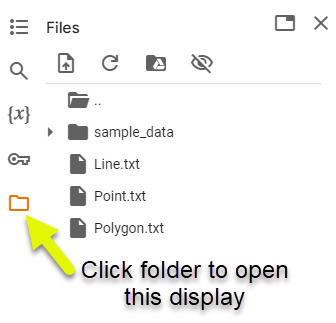

---

In [1]:
from datetime import datetime
import pytz

# @markdown <br><font color="blue"><h2>Enter the start time (in UTC) for the plots</h2></font>
start_date = "2024-07-16" # @param {type:"date"}
start_hour = "00" # @param ["00","01","02","03","04","05","06","07","08","09","10","11","12","13","14","15","16","17,","18","19","20","21","22","23"]

start_datetime_str = f"{start_date}_{start_hour}:00:00"

# @markdown <br><font color="blue"><h2>Enter the duration in hours</h2></font>
hours_duration = "06" # @param ["00","01","02","03","04","05","06"]

# @markdown <br><font color="blue"><h2>Define lat/lon boundaries to plot</h2></font>
lat_min = 40.0 # @param {type:"raw"}
lat_max = 43.5 # @param {type:"raw"}
lon_min = -92.0 # @param {type:"raw"}
lon_max = -85.0 # @param {type:"raw"}

def make_float(val):
  try:
    return float(val)
  except ValueError as ve:
    print("...... WARNING !! ......................\n")
    print(f"Can't convert {val} to float! --> {ve}\n")
    print("...... Check values and try again ......\n")
    return

lat_min = make_float(lat_min)
lat_max = make_float(lat_max)
lon_min = make_float(lon_min)
lon_max = make_float(lon_max)

bbox = f"{lon_min},{lat_min},{lon_max},{lat_max}"


<font color="blue"><h2>Run code below to generate Point/Line/Polygon placefiles</h2></font></h2></font>

In [2]:
# @title
import os
import requests
import json
import glob
import shutil

# Define the base URL
BASE_URL = "https://services.dat.noaa.gov/arcgis/rest/services/nws_damageassessmenttoolkit/DamageViewer/FeatureServer"
SPATIAL_REFERENCE = "4326"
FEATURE_TYPES = ["Point", "Line", "Polygon"]
ICON_FILE_SMALL = '"https://raw.githubusercontent.com/tjturnage/GIS/main/icons-small.png"'
ICON_FILE_SMALLER = '"https://raw.githubusercontent.com/tjturnage/GIS/main/icons-smaller.png"'

EF_VALUES = {'EF0': {'color': 'Color: 6 254 197\n\n', 'icon_number': 1},
             'EF1': {'color':'Color: 85 253 34\n\n', 'icon_number': 2},
             'EF2': {'color':'Color: 255 254 0\n\n', 'icon_number': 3},
             'EF3': {'color':'Color: 230 152 6\n\n', 'icon_number': 4},
             'EF4': {'color':'Color: 230 0 0\n\n', 'icon_number': 5},
             'EF5': {'color':'Color: 168 10 132\n\n', 'icon_number': 6},
             'EFU': {'color':'Color: 168 168 168\n\n', 'icon_number': 7},
             'N/A': {'color':'Color: 168 168 168\n\n', 'icon_number': 7},
             'TSTM_Wind': {'color':'Color: 211 255 190\n\n', 'icon_number': 8},
             'None': {'color':'Color: 168 168 168\n\n', 'icon_number': 9}
             }

class DAT_Placefiles():
    """
    Utilized the Damage Assessment Toolking REST API to retrieve survey
    data and write three different placefiles corresponding to point,
    line and polygon features associated with a user supplied time range
    and lat/lon bounding box
    """
    def __init__(self, start_datetime_str: str, duration: str, bounding_box: str):
        self.start_datetime_str = start_datetime_str
        self.duration = duration
        self.bounding_box = bounding_box
        self.time_arg = self.make_time_args()
        self.params = self.set_json_parameters()
        self.make_title()
        self.clean_files()
        self.request_data()
        #self.zip_placefiles()

    def clean_files(self) -> None:
        files = ['Line.txt','Point.txt','Polygon.txt','placefiles.zip']
        for file in files:
            if os.path.exists(file): os.remove(file)

    def make_time_args(self) -> str:
        start_ts = int(datetime.strptime(self.start_datetime_str, "%Y-%m-%d_%H:%M:%S").timestamp() * 1000)
        end_ts = start_ts + (int(self.duration) * 60 * 60 * 1000)
        return f"{start_ts}, {end_ts}"

    def timestring_from_timestamp(self, ts) -> str:
        new_ts = int(ts) / 1000
        dts = datetime.fromtimestamp(new_ts)
        return datetime.strftime(dts, "%m/%d/%Y %H:%M:%S UTC")

    def make_title(self) -> None:
        dts = self.start_datetime_str[:10]
        self.title = f'Survey {dts}Z, {self.duration[-1:]}hr(s), {lat_min},{lat_max},{lon_min},{lon_max}'

    def set_json_parameters(self) -> None:
        params = {
            "f": "geojson",
            "geometry": bbox,
            "geometryType": "esriGeometryEnvelope",
            "inSR": SPATIAL_REFERENCE,  # Spatial reference for the input geometry
            "outFields": "*",  # Retrieve all fields
            "outSR": SPATIAL_REFERENCE,  # Output spatial reference
            "time": self.time_arg  # "start_time, end_time in milliseconds since epoch
        }
        return params

    def get_ef_values(self, feature) -> str:
        try:
            ef = feature['properties']['efscale']
            if 'TSTM' in ef:
                ef = 'TSTM_Wind'
            color_line = EF_VALUES[ef]['color']
            icon_number = EF_VALUES[ef]['icon_number']
        except KeyError as ke:
            print(f'Key error! {ke}')
            ef = 'EFU'
            color_line = 'Color: 125 125 125\n\n'
            icon_number = '9'
        return color_line, ef, icon_number

    def write_metadata(self) -> str:
        pretty_ts = f'{self.start_datetime_str[:-3]} UTC'
        meta = f';\n'
        meta += f'; Retrieved from:\n'
        meta += f';  {BASE_URL}\n'
        meta += f';     Bounding box - lat_range: {lat_min}, {lat_max}\n'
        meta += f';                  - lon_range: {lon_min}, {lon_max}\n'
        meta += f';            Start - {pretty_ts}\n'
        meta += f';         Duration - {self.duration} hours\n'
        meta += f';  Placefile iconfile option:\n'
        meta += f';  {ICON_FILE_SMALL}\n'
        meta += f';  {ICON_FILE_SMALLER}\n\n'
        return meta

    def make_line_feature(self, feature) -> str:
        """
        """
        feature_string = ''
        color_line, ef, _icon_number = self.get_ef_values(feature)
        geometry = feature['geometry']['coordinates']
        feature_string += color_line
        line_info = f'Line: 1, 0, " {ef} "\n'
        feature_string += line_info

        for c, coord in enumerate(geometry):
            feature_string += f'{coord[1]}, {coord[0]}\n'

        feature_string += "End: \n\n"
        return feature_string

    def make_polygon_feature(self, feature) -> str:
        """
        """
        feature_string = ''
        color_line, ef, _icon_number = self.get_ef_values(feature)
        geometry = feature['geometry']['coordinates'][0]
        feature_string += color_line
        line_info = f'Line: 1, 0, " {ef} "\n'
        feature_string += line_info

        for c, coord in enumerate(geometry):
            feature_string += f'{coord[1]}, {coord[0]}\n'

        feature_string += "End: \n\n"
        return feature_string

    def make_point_feature(self, feature) -> str:
        """
        parse out some of the following fields
            "properties": {
                "comments": " ...",
                "damage": 1,
                "damage_dir": "N/A",
                "damage_txt": "Small Barns or Farm Outbuildings (SBO)",
                "deaths": 0,
                "device_id": null,
                "dod": 7,
                "dod_txt": "Overturning or sliding of entire structure",
                "edit_time": null,
                "edit_user": "xxx_noaa",
                "efscale": "EF1",
                "event_id": "xxxxx",
                "globalid": "{72842C59-6FDC-4419-A85C-5392F79CB4DB}",
                "gps_horiz_accuracy": 2.9383,
                "image": null,
                "injuries": 0,
                "lat": 41.9585,
                "lon": -103.8586,
                "objectid": 4072450,
                "office": "CYS",
                "path_guid": null,
                "qc": "Y",
                "stormdate": 1718919180000,
                "surveydate": 1718991420000,
                "surveytype": null,
                "windspeed": "100"
        """
        feature_string = ''
        color_line, ef, icon_number = self.get_ef_values(feature)
        coords = feature['geometry']['coordinates']

        lat, lon = coords[1], coords[0]
        location = f'Object: {lat}, {lon}\n'
        feature_string += location
        #feature_string += 'Threshold: 999\n'
        feature_string += 'Threshold: 150\n'

        # get details
        details = ''
        event_timestamp = feature['properties']['stormdate']
        event_timestring = self.timestring_from_timestamp(event_timestamp)
        details += f'{event_timestring}\\n'

        windspeed = feature['properties']['windspeed']
        details += f'{ef} -- {windspeed} MPH\\n'

        try:
            dod_text = feature['properties']['dod_txt']
            details += f'{dod_text}\\n'
        except KeyError as ke:
            dod_text = ''

        try:
            comments = feature['properties']['comments']
            if comments is not None and len(comments) > 30:
               comments = comments[:30]
            # skip comments for now
            #details += f'{comments}\\n'
        except KeyError as ke:
            comments = ''

        try:
            office = feature['properties']['office']
            details += f'WFO: {office}\\n'
        except KeyError as ke:
            office = ''

        icon_string = f' Icon: 0, 0, 000, 1, {icon_number}, " {details}"\n'
        feature_string += icon_string
        feature_string += "End: \n\n"
        return feature_string

    def write_placefile(self, json, feature_type: str) -> None:
        """
        Input:
        feature_type: string
            Options are "Point", "Line", or "Polygon"
            This informs:
                - part of the name of the Title in the heading
                - name of the file to write to
        First writes the heading of the placefile

        """
        if len(json['features']) > 0:
            with open(f'{feature_type}.txt', 'w', encoding='utf-8') as fout:
                # Write heading
                metadata = self.write_metadata()
                fout.write(metadata)
                fout.write(f'Title: {self.title} -- {feature_type}\n')
                fout.write('Refresh: 90\n')
                fout.write('Threshold: 999\n')
                fout.write(f'IconFile: 1, 20, 20, 10, 10, {ICON_FILE_SMALLER}\n\n')
                # Now loop through features
                for feature in json['features']:
                    if feature_type == 'Point':
                        this_feature = self.make_point_feature(feature)
                    elif feature_type == 'Line':
                        this_feature = self.make_line_feature(feature)
                    else:
                        this_feature = self.make_polygon_feature(feature)
                    fout.write(this_feature)
        else:
            print(f'No {feature_type} features found!')


    def zip_placefiles(self) -> None:
        text_files = glob.glob('*.txt')
        shutil.make_archive(f'DAT_placefiles', 'zip', '/content/graphics')

    def request_data(self) -> None:
        for n, request_type in enumerate(FEATURE_TYPES):
            url = f'{BASE_URL}/{n}/query'
            response = requests.get(url, params=self.params, timeout=10)
            # Check if the request was successful
            if response.status_code == 200:
                # Parse the GeoJSON from the response
                this_json = response.json()
                #data = json.dumps(this_json, sort_keys=True, indent=4)
                #print(data)
                self.write_placefile(this_json,request_type)

            else:
                print("Failed to retrieve data:", response.status_code)

if __name__ == '__main__':
    DAT_Placefiles(start_datetime_str, hours_duration, bbox)
